In [1]:
# libraries
import os
import subprocess
import numpy as np
import pandas as pd
import scipy
from scipy import signal
import ripple_detection
from ripple_detection import filter_ripple_band
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import windows
from scipy.ndimage import convolve
from scipy import stats
from tqdm import tqdm
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from scipy import interpolate
from scipy.signal import firwin, lfilter
from fitter import Fitter, get_common_distributions, get_distributions
import time
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import zscore
from scipy.ndimage.filters import gaussian_filter
import glob
import pickle

plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["text.usetex"] = False
plt.rcParams["font.weight"] = "bold"

/tmp/ipykernel_15583/1386369103.py:25: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [2]:
gamma_filter_path = "/home/acampbell/NeuropixelsLFPOnRamp/PowerBandFilters/swr_detection_script_filters_1500Hz/frank2008_gamma_1500hz_bandpass_filter.npz"
# The path to the theta filter
theta_filter_path = "/home/acampbell/NeuropixelsLFPOnRamp/PowerBandFilters/swr_detection_script_filters_1500Hz/theta_1500hz_bandpass_filter.npz"
# The ripple band threshold

# loading filters (craetes artifacts in first and last ~ 3.5 seconds of recordings, remember to clip these off)
gamma_filter = np.load(gamma_filter_path)
gamma_filter = gamma_filter["arr_0"]

theta_filter = np.load(theta_filter_path)
theta_filter = theta_filter["arr_0"]
sdk_cache_dir = "/space/scratch/allen_viscoding_data"
# Setting up the ABI Cache (where data is held, what is present or absent)
manifest_path = os.path.join(sdk_cache_dir, "manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

# we start by calling and filtering our dataframe of the sessions we will be working with
sessions = cache.get_session_table()

In [3]:
# change this to your local
abi_swrs_dir_path = (
    "/space/scratch/allen_visbehave_swr_data/allen_viscoding_swr_murphylab2024"
)
abi_lfp_dir_path = (
    "/space/scratch/allen_visbehave_swr_data/allen_viscoding_swr_murphylab2024_lfp_data"
)

In [4]:
import os
import re

# Get a list of all directories in abi_swrs_dir_path
directories = os.listdir(abi_swrs_dir_path)

# Initialize an empty list to store the IDs
ids = []

# Iterate over the directories
for directory in directories:
    # If the directory name starts with 'swrs_session_', extract the ID
    if directory.startswith("swrs_session_"):
        id = re.sub("swrs_session_", "", directory)
        ids.append(id)

# Print the list of IDs
print(ids)

['797828357', '821695405', '750749662', '816200189', '835479236', '774875821', '762602078', '760345702', '750332458', '794812542', '719161530', '779839471', '839068429', '751348571', '829720705', '793224716', '757216464', '763673393', '789848216', '761418226', '778998620', '771990200', '767871931', '757970808', '773418906', '781842082', '787025148', '755434585', '786091066', '766640955', '758798717', '799864342', '831882777', '754829445', '819186360', '791319847', '746083955', '771160300', '798911424', '743475441', '744228101', '768515987', '759883607', '819701982', '754312389', '721123822', '778240327']


In [5]:
session_id = 721123822

In [6]:
swrs_session_path = f"{abi_swrs_dir_path}/swrs_session_{session_id}/"
lfp_session_path = f"{abi_lfp_dir_path}/lfp_session_{session_id}/"

In [7]:
swrs_session_path

'/space/scratch/allen_visbehave_swr_data/allen_viscoding_swr_murphylab2024/swrs_session_721123822/'

In [8]:
global_swrs_df = pd.read_csv(
    f"{swrs_session_path}/session_{session_id}_putative_global_swrs_no_movement_no_gamma.csv",
    compression="gzip",
)

In [9]:
global_swrs_df

,start_time,end_time,probes_event_is_on,events_row_index,global_peak_time,global_max_zscore,peak_probe
0,3.778925,3.810256,[760213142],[0],3.798257,3.736325,760213142
1,6.761085,6.795084,[760213145],[0],6.785751,4.637297,760213145
2,11.815478,11.850809,[760213145],[1],11.832810,4.345390,760213145
3,11.885153,12.172792,"[760213142, 760213145]","[1, 2]",12.045466,5.209288,760213145
4,12.660099,12.729428,[760213145],[3],12.704763,3.471327,760213145
...,...,...,...,...,...,...,...
12011,9809.292246,9809.360242,[760213137],[4996],9809.314911,3.396990,760213137
12012,9809.562460,9809.797551,"[760213142, 760213137]","[3251, 4997]",9809.764219,3.926749,760213137
12013,9809.880880,9809.981771,"[760213142, 760213137, 760213145]","[3252, 4998, 4999, 4166]",9809.890213,4.491839,760213137
12014,9810.178528,9810.222526,[760213147],[3316],9810.209860,4.360947,760213147


In [10]:
def plot_event_all_sesh_probes_abi(
    lfp_sesh_path, event_df, event_index, window=0.5, plot_ripple_band=False
):
    """
    AllenLFP plotting from saved LFP folder, around a specific event going from most medial to least medial.

    Parameters:
    lfp_sesh_path (str): Path to the directory containing LFP session data.
    event_df (pd.DataFrame): DataFrame containing event data with columns like 'start_time', 'end_time', etc.
    event_index (int): The index of the event to plot around.
    window (float): The time window (in seconds) around the event to plot.
    plot_ripple_band (bool): Whether to plot the ripple band alongside the LFP trace.
    """
    sid = int(re.search(r"lfp_session_(\d+)", lfp_sesh_path).group(1))
    this_session = cache.get_session_data(sid)

    # Initialize an empty DataFrame to store the channel ids and probe ids
    df = pd.DataFrame(columns=["channel_id", "probe_id", "left_right_ccf_coordinate"])

    # Iterate over all files in the directory
    for file_name in os.listdir(lfp_sesh_path):
        # Check if the file name contains 'lfp_ca1_peakripplepower.npz'
        if "lfp_ca1_peakripplepower.npz" in file_name:
            # Extract the channel_id and probe_id from the file_name
            channel_id = int(re.search(r"channel_(\d+)_", file_name).group(1))
            probe_id = int(re.search(r"probe_(\d+)_", file_name).group(1))

            # Get the left_right value for the current channel_id
            left_right = this_session.channels.loc[
                channel_id, "left_right_ccf_coordinate"
            ]

            # Add the channel_id, probe_id, and left_right value to the DataFrame
            df = pd.concat(
                [
                    df,
                    pd.DataFrame(
                        {
                            "channel_id": [channel_id],
                            "probe_id": [probe_id],
                            "left_right_ccf_coordinate": [left_right],
                        }
                    ),
                ],
                ignore_index=True,
            )

    # Sort the DataFrame by left_right
    df = df.sort_values(by="left_right_ccf_coordinate")

    # Get the probe_ids and channel_ids in order of left_right
    probe_ids = df["probe_id"].values.astype(int)
    channel_ids = df["channel_id"].values.astype(int)

    # Get the event details
    event = event_df.iloc[event_index]
    start_time = event["start_time"]
    end_time = event["end_time"]
    event_probes = [int(x) for x in re.findall(r"\d+", event["probes_event_is_on"])]

    # Calculate the time window around the event
    window_start = start_time - window
    window_end = end_time + window

    # Load time data
    time_data = {}
    for file_name in os.listdir(lfp_sesh_path):
        if "lfp_time_index_1500hz.npz" in file_name:
            probe_id = int(re.search(r"probe_(\d+)_", file_name).group(1))
            time_npz = np.load(os.path.join(lfp_sesh_path, file_name))
            if "lfp_time_index" in time_npz:
                time_data[probe_id] = time_npz["lfp_time_index"]
            else:
                print(
                    f"'lfp_time_index' key not found in {file_name}. Available keys: {list(time_npz.keys())}"
                )
                continue

    # Plot the LFP data from each probe within the specified window
    fig, axes = plt.subplots(len(channel_ids), 1, figsize=(15, 10), sharex=True)

    for idx, (channel_id, probe_id) in enumerate(zip(channel_ids, probe_ids)):
        # Load the LFP data for the current channel
        lfp_file_name = (
            f"probe_{probe_id}_channel_{channel_id}_lfp_ca1_peakripplepower.npz"
        )
        print(f"Plotting from file: {lfp_file_name}")
        lfp_data = np.load(os.path.join(lfp_sesh_path, lfp_file_name))

        # Use the correct time data for the current probe
        if probe_id in time_data:
            time = time_data[probe_id]
        else:
            print(f"Time data for probe {probe_id} not found.")
            continue

        if "lfp_ca1" in lfp_data:
            signal = lfp_data["lfp_ca1"]
        else:
            print(
                f"'lfp_ca1' key not found in {lfp_file_name}. Available keys: {list(lfp_data.keys())}"
            )
            continue

        # Filter the entire signal for the ripple band if the option is enabled
        if plot_ripple_band:
            ripple_band = filter_ripple_band(signal)
            ripple_band_zscored = zscore(ripple_band, axis=0)

        # Select the data within the time window
        window_mask = (time >= window_start) & (time <= window_end)
        time_window = time[window_mask]
        signal_window = signal[window_mask]

        if plot_ripple_band:
            ripple_band_window = ripple_band_zscored[window_mask]

        # Check if the signal is multi-dimensional
        if signal_window.ndim > 1:
            # Process each channel separately
            for ch_idx in range(signal_window.shape[1]):
                signal_ch = signal_window[:, ch_idx]

                # Plot LFP signal on the left axis
                axes[idx].plot(
                    time_window,
                    signal_ch,
                    label=f"Channel {channel_id} (Probe {probe_id}, Ch {ch_idx})",
                )

                # Plot the ripple band on the right axis
                if plot_ripple_band:
                    ax2 = axes[idx].twinx()
                    ax2.plot(
                        time_window,
                        ripple_band_window[:, ch_idx],
                        color="black",
                        alpha=0.3,
                        label="Ripple Band (Z-scored)",
                    )

                # Plot the shaded area only if the probe is in the event's probe list
                if probe_id in event_probes:
                    axes[idx].axvspan(start_time, end_time, color="red", alpha=0.3)
        else:
            # Plot LFP signal on the left axis
            axes[idx].plot(
                time_window,
                signal_window,
                label=f"Channel {channel_id} (Probe {probe_id})",
            )

            # Plot the ripple band on the right axis
            if plot_ripple_band:
                ax2 = axes[idx].twinx()
                ax2.plot(
                    time_window,
                    ripple_band_window[:, None],
                    color="black",
                    alpha=0.3,
                    label="Ripple Band (Z-scored)",
                )

            # Plot the shaded area only if the probe is in the event's probe list
            if probe_id in event_probes:
                axes[idx].axvspan(start_time, end_time, color="red", alpha=0.3)

        # Set the axis limits to match the data range exactly
        axes[idx].set_xlim(window_start, window_end)
        axes[idx].set_ylim(np.min(signal_window), np.max(signal_window))

        # Add labels and legend
        axes[idx].set_xlabel("Time (s)")
        axes[idx].set_ylabel("LFP Signal (V)")
        # axes[idx].legend(loc='upper left')

        if plot_ripple_band:
            ax2.set_ylabel("Z-scored Ripple Band")

    plt.tight_layout()
    plt.show()

In [11]:
global_swrs_df.sort_values("global_max_zscore", ascending=False)

,start_time,end_time,probes_event_is_on,events_row_index,global_peak_time,global_max_zscore,peak_probe
5583,5747.664329,5747.760097,"[760213137, 760213147]","[1744, 1192]",5747.720993,50.245713,760213147
8197,7608.284060,7608.473587,"[760213142, 760213145, 760213147]","[2194, 3195, 2084]",7608.371158,48.410043,760213147
8203,7613.880187,7613.979515,"[760213142, 760213147]","[2195, 2086]",7613.942184,46.131377,760213147
8037,7516.004640,7516.213568,"[760213142, 760213137, 760213145, 760213147]","[2161, 2862, 3154, 2001]",7516.123261,38.264154,760213145
7436,7137.769481,7137.883480,"[760213142, 760213137, 760213145, 760213147]","[2016, 2547, 2970, 1844]",7137.822439,32.840263,760213145
...,...,...,...,...,...,...,...
1779,2758.409522,2758.457520,[760213137],[419],2758.419522,2.189478,760213137
2879,3755.717150,3755.801812,[760213145],[1457],3755.744482,2.179502,760213145
973,1691.600986,1691.658316,[760213137],[181],1691.609652,2.174531,760213137
9535,8460.362222,8460.397553,[760213147],[2575],8460.368222,2.164244,760213147


Plotting from file: probe_760213137_channel_850244337_lfp_ca1_peakripplepower.npz
Plotting from file: probe_760213142_channel_850245137_lfp_ca1_peakripplepower.npz
Plotting from file: probe_760213145_channel_850245801_lfp_ca1_peakripplepower.npz
Plotting from file: probe_760213147_channel_850246609_lfp_ca1_peakripplepower.npz


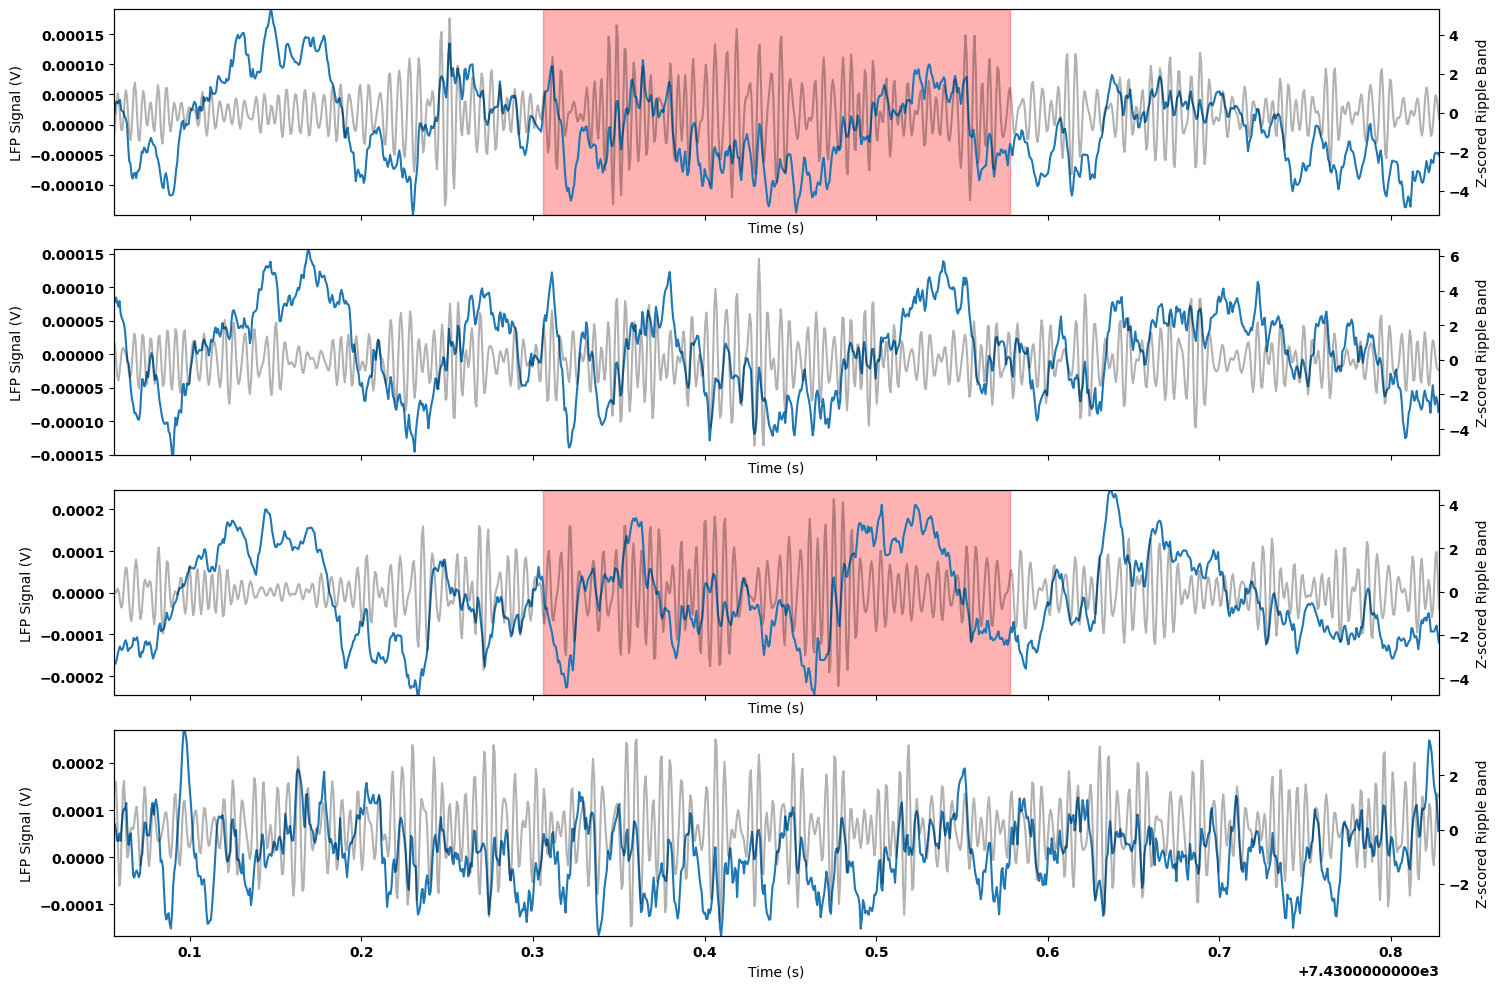

In [12]:
# Example usage
lfp_sesh_path = "/space/scratch/allen_visbehave_swr_data/allen_viscoding_swr_murphylab2024_lfp_data/lfp_session_721123822/"
evnt_idx = 7913
plot_event_all_sesh_probes_abi(
    lfp_sesh_path,
    event_df=global_swrs_df,
    event_index=evnt_idx,
    window=0.25,
    plot_ripple_band=True,
)

In [13]:
def plot_event_all_sesh_probes_abi_v2(
    lfp_sesh_path,
    event_df,
    event_index,
    line_width,
    fig_filename="",
    fig_format="",
    save_fig=True,
    window=0.5,
    plot_ripple_band=False,
    fig_size_mm=(150, 100),
    fig_dpi=300,
):
    """
    AllenLFP plotting from saved LFP folder, around a specific event going from most medial to least medial.

    Parameters:
    lfp_sesh_path (str): Path to the directory containing LFP session data.
    event_df (pd.DataFrame): DataFrame containing event data with columns like 'start_time', 'end_time', etc.
    event_index (int): The index of the event to plot around.
    window (float): The time window (in seconds) around the event to plot.
    plot_ripple_band (bool): Whether to plot the ripple band alongside the LFP trace.
    """
    sid = int(re.search(r"lfp_session_(\d+)", lfp_sesh_path).group(1))
    this_session = cache.get_session_data(sid)

    # Initialize an empty DataFrame to store the channel ids and probe ids
    df = pd.DataFrame(columns=["channel_id", "probe_id", "left_right_ccf_coordinate"])

    # Iterate over all files in the directory
    for file_name in os.listdir(lfp_sesh_path):
        # Check if the file name contains 'lfp_ca1_peakripplepower.npz'
        if "lfp_ca1_peakripplepower.npz" in file_name:
            # Extract the channel_id and probe_id from the file_name
            channel_id = int(re.search(r"channel_(\d+)_", file_name).group(1))
            probe_id = int(re.search(r"probe_(\d+)_", file_name).group(1))

            # Get the left_right value for the current channel_id
            left_right = this_session.channels.loc[
                channel_id, "left_right_ccf_coordinate"
            ]

            # Add the channel_id, probe_id, and left_right value to the DataFrame
            df = pd.concat(
                [
                    df,
                    pd.DataFrame(
                        {
                            "channel_id": [channel_id],
                            "probe_id": [probe_id],
                            "left_right_ccf_coordinate": [left_right],
                        }
                    ),
                ],
                ignore_index=True,
            )

    # Sort the DataFrame by left_right
    df = df.sort_values(by="left_right_ccf_coordinate")

    # Get the probe_ids and channel_ids in order of left_right
    probe_ids = df["probe_id"].values.astype(int)
    channel_ids = df["channel_id"].values.astype(int)

    # Get the event details
    event = event_df.iloc[event_index]
    start_time = event["start_time"]
    end_time = event["end_time"]
    event_probes = [int(x) for x in re.findall(r"\d+", event["probes_event_is_on"])]

    # Calculate the time window around the event
    window_start = start_time - window
    window_end = end_time + window

    # Load time data
    time_data = {}
    for file_name in os.listdir(lfp_sesh_path):
        if "lfp_time_index_1500hz.npz" in file_name:
            probe_id = int(re.search(r"probe_(\d+)_", file_name).group(1))
            time_npz = np.load(os.path.join(lfp_sesh_path, file_name))
            if "lfp_time_index" in time_npz:
                time_data[probe_id] = time_npz["lfp_time_index"]
            else:
                print(
                    f"'lfp_time_index' key not found in {file_name}. Available keys: {list(time_npz.keys())}"
                )
                continue

    plt.rcParams["svg.fonttype"] = "none"
    plt.rcParams["text.usetex"] = False  # Do not use LaTeX for rendering text
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["font.size"] = 8
    plt.rcParams["axes.titleweight"] = "bold"  # Make the title bold
    plt.rcParams["axes.labelweight"] = "bold"

    # Plot the LFP data from each probe within the specified window
    fig_size_in = (
        fig_size_mm[0] / 25.4,
        fig_size_mm[1] / 25.4,
    )  # Convert size from mm to inches
    fig, axes = plt.subplots(len(channel_ids), 1, figsize=fig_size_in, sharex=True)

    for idx, (channel_id, probe_id) in enumerate(zip(channel_ids, probe_ids)):
        # Load the LFP data for the current channel
        lfp_file_name = (
            f"probe_{probe_id}_channel_{channel_id}_lfp_ca1_peakripplepower.npz"
        )
        print(f"Plotting from file: {lfp_file_name}")
        lfp_data = np.load(os.path.join(lfp_sesh_path, lfp_file_name))

        # Use the correct time data for the current probe
        if probe_id in time_data:
            time = time_data[probe_id]
        else:
            print(f"Time data for probe {probe_id} not found.")
            continue

        if "lfp_ca1" in lfp_data:
            signal = lfp_data["lfp_ca1"]
        else:
            print(
                f"'lfp_ca1' key not found in {lfp_file_name}. Available keys: {list(lfp_data.keys())}"
            )
            continue

        # Filter the entire signal for the ripple band if the option is enabled
        if plot_ripple_band:
            ripple_band = filter_ripple_band(signal)

        # Select the data within the time window
        window_mask = (time >= window_start) & (time <= window_end)
        time_window = time[window_mask]
        signal_window = signal[window_mask]
        # convert it to microvolts
        signal_window = signal_window * 1e6

        if plot_ripple_band:
            ripple_band_window = ripple_band[window_mask] * 1e6

        # Check if the signal is multi-dimensional
        if signal_window.ndim > 1:
            # Process each channel separately
            for ch_idx in range(signal_window.shape[1]):
                signal_ch = signal_window[:, ch_idx]

                # Plot LFP signal on the left axis
                # axes[idx].plot(time_window, signal_ch, label=f'Channel {channel_id} (Probe {probe_id})')
                axes[idx].plot(time_window, signal_ch, linewidth=line_width)

                # Plot the ripple band on the right axis
                if plot_ripple_band:
                    ax2 = axes[idx].twinx()
                    ax2.plot(
                        time_window,
                        ripple_band_window[:, ch_idx],
                        color="black",
                        linewidth=line_width,
                        alpha=0.7,
                        label="Ripple Band (150-250Hz, uV)",
                    )

                # Plot the shaded area only if the probe is in the event's probe list
                if probe_id in event_probes:
                    axes[idx].axvspan(start_time, end_time, color="green", alpha=0.2)
        else:
            # Plot LFP signal on the left axis
            axes[idx].plot(
                time_window,
                signal_window,
                color="black",
                linewidth=line_width,
                label=f"Channel {channel_id} (Probe {probe_id})",
            )

            # Plot the ripple band on the right axis
            if plot_ripple_band:
                ax2 = axes[idx].twinx()
                # ax2.plot(time_window, ripple_band_window[:, None], color='black', alpha=0.3, label='Ripple Band (150-250Hz, uV)')

            # Plot the shaded area only if the probe is in the event's probe list
            if probe_id in event_probes:
                axes[idx].axvspan(start_time, end_time, color="green", alpha=0.2)

        # Set the axis limits to match the data range exactly
        axes[idx].set_xlim(window_start, window_end)
        # axes[idx].set_ylim(np.min(signal_window), np.max(signal_window))
        axes[idx].set_ylim(-700, 300)

        # Add labels and legend
        if idx == len(channel_ids) - 1:  # Only label the x-axis on the last subplot
            xlabel = axes[idx].set_xlabel("Time (s)")
            xlabel.set_fontsize(14)
            xlabel.set_weight("bold")
        ylabel1 = axes[idx].set_ylabel("")
        ylabel1.set_fontsize(14)
        ylabel1.set_weight("bold")
        axes[idx].legend(loc="upper left")

        if plot_ripple_band:
            # ylabel2 = ax2.set_ylabel('Ripple Band (150-250Hz, uV)')
            # ylabel2.set_fontsize(14)
            # ylabel2.set_weight('bold')
            ax2.set_ylim(-200, 200)
            # ax2.yticks(np.arange(-200, 201, 100))

        # add overal axis labels
        fig.text(
            -0.01,
            0.5,
            "LFP Signal (uV)",
            va="center",
            rotation="vertical",
            fontsize=14,
            weight="bold",
        )
        if plot_ripple_band:
            fig.text(
                1.01,
                0.5,
                "Ripple Band (150-250Hz)",
                va="center",
                rotation="vertical",
                fontsize=14,
                weight="bold",
            )

    plt.tight_layout()
    if save_fig == True:
        plt.savefig(fig_filename, format=fig_format)
    plt.show()

Plotting from file: probe_760213137_channel_850244337_lfp_ca1_peakripplepower.npz


No handles with labels found to put in legend.


Plotting from file: probe_760213142_channel_850245137_lfp_ca1_peakripplepower.npz


No handles with labels found to put in legend.


Plotting from file: probe_760213145_channel_850245801_lfp_ca1_peakripplepower.npz


No handles with labels found to put in legend.


Plotting from file: probe_760213147_channel_850246609_lfp_ca1_peakripplepower.npz


No handles with labels found to put in legend.


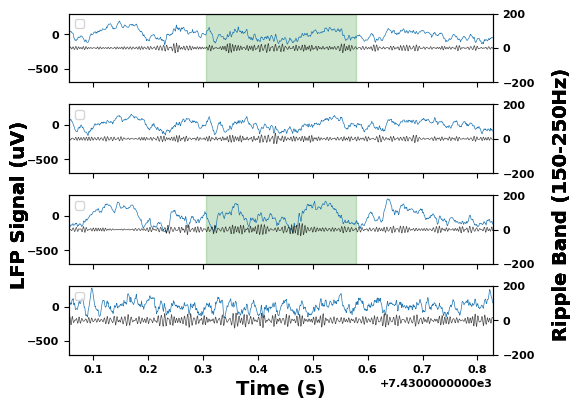

In [14]:
# Example usage
lfp_sesh_path = "/space/scratch/allen_visbehave_swr_data/allen_viscoding_swr_murphylab2024_lfp_data/lfp_session_721123822/"
evnt_idx = 7913
filepathandname = "/home/acampbell/NeuropixelsLFPOnRamp/Figures_and_Technical_Validation/figures/figure1/figure_three_c_smol.svg"
plot_event_all_sesh_probes_abi_v2(
    lfp_sesh_path,
    event_df=global_swrs_df,
    event_index=evnt_idx,
    line_width=0.5,
    fig_filename=filepathandname,
    fig_format="svg",
    save_fig=False,
    window=0.25,
    plot_ripple_band=True,
    fig_size_mm=(135, 105),
    fig_dpi=400,
)

## Mouse information for tables

This code was how the data for the tables was collected.

In [15]:
import os
from math import floor

abi_viscoding_ripples_path = (
    "/space/scratch/allen_visbehave_swr_data/allen_viscoding_swr_murphylab2024"
)

# Assuming cache.get_ecephys_session_table() has been called to populate 'sessions'
sessions = cache.get_session_table()

unique_mouse_ids = set()
karlsson_count_per_mouse = {}  # Dictionary to store 'karlsson' file counts per mouse

for sessionfolder in os.listdir(abi_viscoding_ripples_path):
    if ".csv" in sessionfolder:
        continue

    session_id = sessionfolder.split("_")[-1]
    if int(session_id) in sessions.index:
        mouse_id = sessions.loc[int(session_id), "specimen_id"]
        unique_mouse_ids.add(mouse_id)

        # Count 'karlsson' files in the session folder
        karlsson_count = sum(
            "karlsson" in filename
            for filename in os.listdir(
                os.path.join(abi_viscoding_ripples_path, sessionfolder)
            )
        )
        karlsson_count_per_mouse[mouse_id] = (
            karlsson_count_per_mouse.get(mouse_id, 0) + karlsson_count
        )

# Filter the sessions DataFrame for these unique mouse IDs
filtered_sessions = sessions[sessions["specimen_id"].isin(unique_mouse_ids)]

# Now group by 'mouse_id' to get mouse_info for later use
mouse_info = filtered_sessions.groupby("specimen_id")

# Example usage: print genotype, strain, age, sex, and 'karlsson' file count for each mouse
for mouse_id, group in mouse_info:
    print(f"Genotype: {group['full_genotype'].iloc[0]}")
    print(f"Age (Weeks): {floor(group['age_in_days'].iloc[0]/7)}")
    print(f"Sex: {group['sex'].iloc[0]}")
    print(f"Probes in CA1 count: {karlsson_count_per_mouse.get(mouse_id, 0)}\n")

Genotype: Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
Age (Weeks): 17
Sex: M
Probes in CA1 count: 5

Genotype: Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
Age (Weeks): 17
Sex: M
Probes in CA1 count: 4

Genotype: wt/wt
Age (Weeks): 17
Sex: M
Probes in CA1 count: 5

Genotype: wt/wt
Age (Weeks): 20
Sex: M
Probes in CA1 count: 6

Genotype: wt/wt
Age (Weeks): 17
Sex: M
Probes in CA1 count: 5

Genotype: wt/wt
Age (Weeks): 13
Sex: M
Probes in CA1 count: 1

Genotype: wt/wt
Age (Weeks): 13
Sex: M
Probes in CA1 count: 6

Genotype: Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
Age (Weeks): 14
Sex: F
Probes in CA1 count: 1

Genotype: wt/wt
Age (Weeks): 20
Sex: M
Probes in CA1 count: 5

Genotype: wt/wt
Age (Weeks): 15
Sex: M
Probes in CA1 count: 5

Genotype: Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
Age (Weeks): 14
Sex: M
Probes in CA1 count: 4

Genotype: Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
Age (Weeks): 13
Sex: F
Probes in CA1 count: 5

Genotype: wt/wt
Age (Weeks): 15
Sex: M
P

## Number of ripples by thresholds

In [16]:
abi_ripples_path = (
    "/space/scratch/allen_visbehave_swr_data/allen_viscoding_swr_murphylab2024"
)
abi_lfp_path = (
    "/space/scratch/allen_visbehave_swr_data/allen_viscoding_swr_murphylab2024_lfp_data"
)
theta_filter_path = "/home/acampbell/NeuropixelsLFPOnRamp/PowerBandFilters/swr_detection_script_filters_1500Hz/theta_1500hz_bandpass_filter.npz"
theta_filter = np.load(theta_filter_path)
theta_filter = theta_filter["arr_0"]

In [17]:
minpeak2p5_nogamma = []
minpeak3_nogamma = []
minpeak5_nogamma = []
minpeak2p5_gamma = []
minpeak3_gamma = []
minpeak5_gamma = []
seshIDs = []
failed_sesh = []
absent_gamma = []
absent_nogamma = []

for sessionfolder in os.listdir(abi_ripples_path):
    session_id = sessionfolder.split("_")[-1]
    try:
        if ".csv" in sessionfolder:
            continue

        folder_path = os.path.join(abi_ripples_path, sessionfolder)
        folderfiles = os.listdir(folder_path)
        global_swrs_gamma_file = [
            file for file in folderfiles if "global_swrs_no_movement.csv" in file
        ][0]
        global_swrs_nogamma_file = [
            file
            for file in folderfiles
            if "global_swrs_no_movement_no_gamma.csv" in file
        ][0]
        rips_gamma_df = pd.read_csv(
            os.path.join(folder_path, global_swrs_gamma_file), compression="gzip"
        )
        rips_nogamma_df = pd.read_csv(
            os.path.join(folder_path, global_swrs_nogamma_file), compression="gzip"
        )
        minpeak2p5_nogamma.append(
            rips_nogamma_df[rips_nogamma_df.global_max_zscore > 2.5].shape[0]
        )
        minpeak3_nogamma.append(
            rips_nogamma_df[rips_nogamma_df.global_max_zscore > 3].shape[0]
        )
        minpeak5_nogamma.append(
            rips_nogamma_df[rips_nogamma_df.global_max_zscore > 5].shape[0]
        )
        minpeak2p5_gamma.append(
            rips_gamma_df[rips_gamma_df.global_max_zscore > 2.5].shape[0]
        )
        minpeak3_gamma.append(
            rips_gamma_df[rips_gamma_df.global_max_zscore > 3].shape[0]
        )
        minpeak5_gamma.append(
            rips_gamma_df[rips_gamma_df.global_max_zscore > 5].shape[0]
        )
        seshIDs.append(str(session_id))
    except:
        failed_sesh.append(session_id)
        print(f"failed session {session_id}")
        folder_path = os.path.join(abi_ripples_path, sessionfolder)
        folderfiles = os.listdir(folder_path)
        if not any(
            "global_swrs_no_movement_no_gamma.csv" in file for file in folderfiles
        ):
            print(f"Absent no_movement_no_gamma file for session {session_id}")
            absent_nogamma.append(session_id)
        if not any("global_swrs_no_movement.csv" in file for file in folderfiles):
            print(f"Absent no_movement file for session {session_id}")
            absent_gamma.append(session_id)
        print(traceback.format_exc())
        continue

print(len(minpeak2p5_nogamma))
print(len(minpeak3_nogamma))
print(len(minpeak5_nogamma))
print(len(minpeak2p5_gamma))
print(len(minpeak3_gamma))
print(len(minpeak5_gamma))
print(len(seshIDs))
print(len(failed_sesh))
print(len(absent_gamma))
print(len(absent_nogamma))

df = pd.DataFrame(
    {
        "Session_ID": seshIDs,
        "Min_Peak_2.5_NoGamma": minpeak2p5_nogamma,
        "Min_Peak_3_NoGamma": minpeak3_nogamma,
        "Min_Peak_5_NoGamma": minpeak5_nogamma,
        "Min_Peak_2.5_Gamma": minpeak2p5_gamma,
        "Min_Peak_3_Gamma": minpeak3_gamma,
        "Min_Peak_5_Gamma": minpeak5_gamma,
    }
)

47
47
47
47
47
47
47
0
0
0


## Plotting all SWRs as a function of speed and theta

In [18]:
abi_ripples_path = (
    "/space/scratch/allen_visbehave_swr_data/allen_viscoding_swr_murphylab2024"
)
abi_lfp_path = (
    "/space/scratch/allen_visbehave_swr_data/allen_viscoding_swr_murphylab2024_lfp_data"
)
theta_filter_path = "/home/acampbell/NeuropixelsLFPOnRamp/PowerBandFilters/swr_detection_script_filters_1500Hz/theta_1500hz_bandpass_filter.npz"
theta_filter = np.load(theta_filter_path)
theta_filter = theta_filter["arr_0"]

In [19]:
def smoothed_vel_from_runningspeed_df(velocity_df):
    """
    Function to convert running speed DataFrame to smoothed velocity array.

    Parameters:
    velocity_df (pd.DataFrame): DataFrame with columns 'start_time', 'end_time', and 'velocity'.

    Returns:
    np.array: Smoothed velocity array.
    time_array: Time array corresponding to the smoothed velocity array.

    """
    velocity_df["time_interval"] = velocity_df["end_time"] - velocity_df["start_time"]

    # Determine the total number of points required at 1500 Hz
    total_points = int(velocity_df["time_interval"].sum() * 1500)

    # Create a time array with the desired number of points
    time_array = np.linspace(
        velocity_df["start_time"].iloc[0],
        velocity_df["end_time"].iloc[-1],
        total_points,
    )

    # Interpolate the velocity signal at 1500 Hz
    interpolated_velocity = interp1d(
        np.hstack((velocity_df["start_time"].values, velocity_df["end_time"].iloc[-1])),
        np.hstack((velocity_df["velocity"].values, velocity_df["velocity"].iloc[-1])),
        kind="linear",
    )(time_array)

    # Create a half Gaussian window for smoothing
    window = windows.gaussian(31, std=0.25)
    window = window / np.sum(window)

    # Smooth the interpolated velocity signal
    smoothed_velocity = convolve(interpolated_velocity, window, mode="reflect")

    # Return the smoothed velocity as a 1D NumPy array

    return np.array(smoothed_velocity), time_array

The code to collect the data used for plotting histograms and computing distributions takes a very long time to run so it has been commented out here.

In [20]:
"""
speeds = []
theta_powers = {'peakwindow_med':[],'peakwindow_mean':[],
                'eventwindow_med':[],'eventwindow_mean':[]}
theta_compute_halfwindow = 0.125
failed_sesh = []

for sessionfolder in os.listdir(abi_ripples_path):
    try:
        if '.csv' in sessionfolder:
            continue 
        folder_path = os.path.join(abi_ripples_path, sessionfolder)
        folderfiles = os.listdir(folder_path)

        global_ripples_filename = [file for file in folderfiles if 'global_swrs' in file][0]

        global_ripples_df = pd.read_csv(os.path.join(folder_path, global_ripples_filename), compression='gzip')
        session_id = int(sessionfolder.split('_')[-1])
        
        # getting speeds
        session = cache.get_session_data(session_id)
        wheel_velocity, wheel_time = smoothed_vel_from_runningspeed_df(session.running_speed)
        
        # Interpolating the wheel velocity to 1500 Hz
        interp_func = interp1d(wheel_time, wheel_velocity)
        wheel_time = np.linspace(wheel_time[0], wheel_time[-1], int(len(wheel_time) * 1500 / len(wheel_time)))
        wheel_velocity = interp_func(wheel_time)
        
        average_speeds = []
        for _, row in global_ripples_df.iterrows():
            start_time = row['start_time']
            end_time = row['end_time']
            mask = (wheel_time >= start_time) & (wheel_time <= end_time)
            average_speed = np.abs(wheel_velocity[mask]).mean()
            average_speeds.append(average_speed)
        
        global_ripples_df['average_speed'] = average_speeds
        speeds.extend(average_speeds)
        
        lfp_session_path = f"{abi_lfp_path}/lfp_session_{str(session_id)}"
        lfp_files = os.listdir(lfp_session_path)
        for file in folderfiles:
            # we load lfp data for the karlsson files, then we compute theta power (zscored) and take that values
            # in a window around the peak of the swr
            if not 'karlsson' in file:
                continue
            
            # load the data
            events_df = pd.read_csv(os.path.join(folder_path,file), compression ='gzip')
            events_df = events_df[(events_df.Overlaps_with_gamma==True) & (events_df.Overlaps_with_movement==True)]
            probe_id = re.search(r'probe_(.*?)_', file).group(1)
            channel_indx = re.search(r'channel_(.*?)_', file).group(1)
            lfp_data = [file for file in lfp_files if f"channel_{channel_indx}" in file and probe_id in file and "ca1_peakripplepower.npz" in file]
            lfp_data = np.load(os.path.join(lfp_session_path,lfp_data[0]))
            lfp_data = lfp_data['lfp_ca1']
            lfp_times = [file for file in lfp_files if f"channel_{channel_indx}" in file and probe_id in file and "time_index_1500hz.npz" in file]
            lfp_times = np.load(os.path.join(lfp_session_path,lfp_times[0]))
            lfp_times = lfp_times['lfp_time_index']
            
            # compute theta power
            #theta_pow_zscore = np.convolve(lfp_data, theta_filter, mode='same')
            theta_pow_zscore = np.convolve(lfp_data.flatten(), theta_filter.flatten(), mode='same')
            theta_pow_zscore = scipy.stats.zscore(np.abs(signal.hilbert(theta_pow_zscore))**2)
            
            for _, event in events_df.iterrows():
                # Compute median and mean for peak window
                peak_start = event['Peak_time'] - theta_compute_halfwindow
                peak_end = event['Peak_time'] + theta_compute_halfwindow
                peak_window_data = theta_pow_zscore[(lfp_times >= peak_start) & (lfp_times <= peak_end)]
                theta_powers['peakwindow_med'].append(np.median(peak_window_data))
                theta_powers['peakwindow_mean'].append(np.mean(peak_window_data))

                # Compute median and mean for event window
                event_window_data = theta_pow_zscore[(lfp_times >= event['start_time']) & (lfp_times <= event['end_time'])]
                theta_powers['eventwindow_med'].append(np.median(event_window_data))
                theta_powers['eventwindow_mean'].append(np.mean(event_window_data))
    except:
        failed_sesh.append(sessionfolder)
"""

# saved to avoid having to regenerate it, only used in debugging, will delete in and this seciton later

# save the speeds and theta powers
# with open('abi_viscoding_theta.pkl', 'wb') as f:
#    pickle.dump(theta_powers, f)

# Save the numpy array
# np.save('abi_viscoding_speeds.npy', speeds)

'\nspeeds = []\ntheta_powers = {\'peakwindow_med\':[],\'peakwindow_mean\':[],\n                \'eventwindow_med\':[],\'eventwindow_mean\':[]}\ntheta_compute_halfwindow = 0.125\nfailed_sesh = []\n\nfor sessionfolder in os.listdir(abi_ripples_path):\n    try:\n        if \'.csv\' in sessionfolder:\n            continue \n        folder_path = os.path.join(abi_ripples_path, sessionfolder)\n        folderfiles = os.listdir(folder_path)\n\n        global_ripples_filename = [file for file in folderfiles if \'global_swrs\' in file][0]\n\n        global_ripples_df = pd.read_csv(os.path.join(folder_path, global_ripples_filename), compression=\'gzip\')\n        session_id = int(sessionfolder.split(\'_\')[-1])\n        \n        # getting speeds\n        session = cache.get_session_data(session_id)\n        wheel_velocity, wheel_time = smoothed_vel_from_runningspeed_df(session.running_speed)\n        \n        # Interpolating the wheel velocity to 1500 Hz\n        interp_func = interp1d(wheel_ti

In [21]:
# Load data from pickle file
with open("abi_viscoding_theta.pkl", "rb") as f:
    theta_powers = pickle.load(f)

# Load data from numpy file
speeds = np.load("abi_viscoding_speeds.npy")

In [22]:
columns = ["peakwindow_med", "peakwindow_mean", "eventwindow_med", "eventwindow_mean"]
nan_indices = []
cleaned_theta_data = {}

for col in columns:
    data = pd.Series(theta_powers[col])
    nan_index = data.index[data.isna()].tolist()
    nan_indices.append(set(nan_index))
    cleaned_theta_data[col] = data.dropna()

# Check if all NaN indices are the same
if len(set.intersection(*nan_indices)) == len(nan_indices[0]):
    print("All NaN indices are the same.")
else:
    print("NaN indices are not the same.")

# Print min and max values of cleaned data
for col, data in cleaned_theta_data.items():
    print(f"For {col}, Min: {data.min()}, Max: {data.max()}")

All NaN indices are the same.
For peakwindow_med, Min: -1.954519408622036, Max: 81.07365972522912
For peakwindow_mean, Min: -1.819185503569708, Max: 76.2166622596301
For eventwindow_med, Min: -1.9664677921337348, Max: 95.58100493862955
For eventwindow_mean, Min: -1.965567696573613, Max: 91.4388993312975


In [23]:
figure_six_path = "/home/acampbell/NeuropixelsLFPOnRamp/Figures_and_Technical_Validation/figures/figure6/"

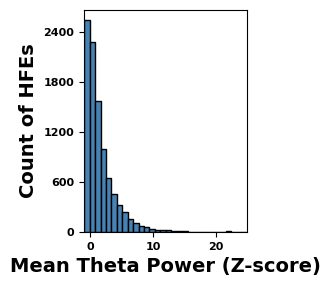

In [24]:
# Ensure text is exported as text objects
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["text.usetex"] = False  # Do not use LaTeX for rendering text
plt.rcParams["font.weight"] = "bold"
plt.rcParams["pdf.use14corefonts"] = False
plt.rcParams["font.size"] = 8
plt.rcParams["axes.titleweight"] = "bold"  # Make the title bold
plt.rcParams["axes.labelweight"] = "bold"

# set figzise in mm
width_mm = 66
height_mm = 73.75

# Set figure size in inches
plt.figure(figsize=(width_mm / 25.4, height_mm / 25.4))

plt.hist(
    cleaned_theta_data["peakwindow_mean"],
    bins=90,
    edgecolor="black",
    facecolor="steelblue",
)
plt.xlim(-1, 25)
plt.xlabel("Mean Theta Power (Z-score)", fontsize=14, weight="bold")
plt.ylabel("Count of HFEs", fontsize=14, weight="bold")
# plt.title('Computed around Peak Window')

# Reduce the number of y-ticks
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(5))

plt.tight_layout()
plt.savefig(f"{figure_six_path}six_coding_a.svg", format="svg")
plt.show()

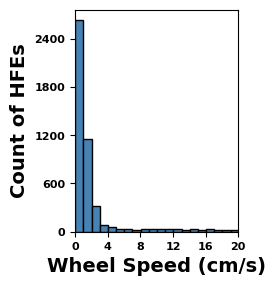

In [25]:
# Ensure text is exported as text objects
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["text.usetex"] = False  # Do not use LaTeX for rendering text
plt.rcParams["font.weight"] = "bold"
plt.rcParams["pdf.use14corefonts"] = False
plt.rcParams["font.size"] = 8
plt.rcParams["axes.titleweight"] = "bold"  # Make the title bold
plt.rcParams["axes.labelweight"] = "bold"

# set figzise in mm
width_mm = 66
height_mm = 73.75

# Set figure size in inches
plt.figure(figsize=(width_mm / 25.4, height_mm / 25.4))

plt.hist(speeds, bins=100, edgecolor="black", facecolor="steelblue")
# Ensure text is exported as text objects
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["text.usetex"] = False  # Do not use LaTeX for rendering text
plt.xlim(0, 20)
plt.xlabel("Wheel Speed (cm/s)", fontsize=14, weight="bold")
plt.ylabel("Count of HFEs", fontsize=14, weight="bold")

# Reduce the number of y-ticks
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(5))
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(5))


plt.tight_layout()
plt.savefig(f"{figure_six_path}six_coding_c.svg", format="svg")
plt.show()

## Ripple Distributions

In [26]:
# getting
directories = os.listdir(abi_ripples_path)

processed_sesh_ids = [
    dir.replace("swrs_session_", "") for dir in directories if "swrs_session_" in dir
]

print(processed_sesh_ids)

['797828357', '821695405', '750749662', '816200189', '835479236', '774875821', '762602078', '760345702', '750332458', '794812542', '719161530', '779839471', '839068429', '751348571', '829720705', '793224716', '757216464', '763673393', '789848216', '761418226', '778998620', '771990200', '767871931', '757970808', '773418906', '781842082', '787025148', '755434585', '786091066', '766640955', '758798717', '799864342', '831882777', '754829445', '819186360', '791319847', '746083955', '771160300', '798911424', '743475441', '744228101', '768515987', '759883607', '819701982', '754312389', '721123822', '778240327']


In [27]:
all_swrs_df = pd.DataFrame()
global_swr_failed_session = []
for sessionfolder in os.listdir(abi_ripples_path):
    try:
        if "global_swrs_no_movement_no_gamma.csv" in sessionfolder:
            continue
        folder_path = os.path.join(abi_ripples_path, sessionfolder)
        folderfiles = os.listdir(folder_path)
        try:
            global_ripples_filename = [
                file for file in folderfiles if "global_swrs" in file
            ][0]

        except:
            continue
        global_ripples_df = pd.read_csv(
            os.path.join(folder_path, global_ripples_filename), compression="gzip"
        )
        global_ripples_df["duration"] = (
            global_ripples_df["end_time"] - global_ripples_df["start_time"]
        )
        global_ripples_df["session_id"] = sessionfolder.replace("swrs_session_", "")
        all_swrs_df = pd.concat([all_swrs_df, global_ripples_df])
    except:
        global_swr_failed_session.append(sessionfolder)

Using fitter we can asses the fit with the KS test and the SSE, and get a p-value from the KS-test.  

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,0.000002,2126.774955,-1.050480e+07,inf,0.013437,3.087147e-64
halfnorm,0.000061,4992.406710,-9.204211e+06,inf,0.085834,0.000000e+00
norm,0.000147,8661.229904,-8.845885e+06,inf,0.138218,0.000000e+00


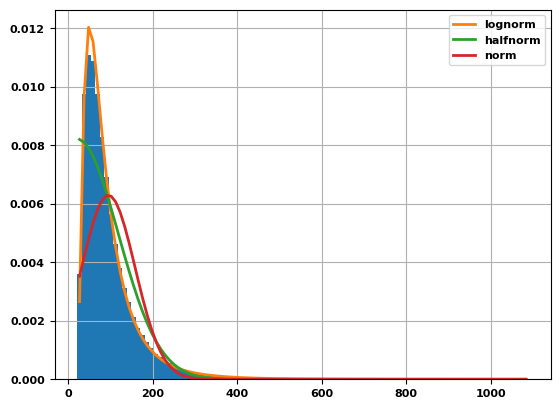

In [28]:
f_distributions_dur = Fitter(
    all_swrs_df["duration"] * 1000, distributions=["norm", "lognorm", "halfnorm"]
)
f_distributions_dur.fit()
f_distributions_dur.summary()

We can also use fitter for plotting the distribution with the fits, though this requires a bit of adjusting the plots

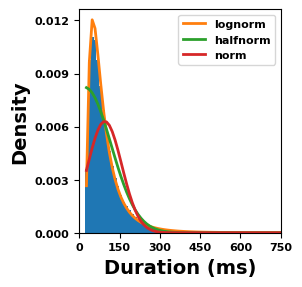

In [29]:
# Ensure text is exported as text objects
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["text.usetex"] = False  # Do not use LaTeX for rendering text
plt.rcParams["font.weight"] = "bold"
plt.rcParams["pdf.use14corefonts"] = False
plt.rcParams["font.size"] = 8
plt.rcParams["axes.titleweight"] = "bold"  # Make the title bold
plt.rcParams["axes.labelweight"] = "bold"

# set figzise in mm
width_mm = 66
height_mm = 73.75

# Set figure size in inches
plt.figure(figsize=(width_mm / 25.4, height_mm / 25.4))

# Plot the histogram
f_distributions_dur.hist()

# Plot the PDF
f_distributions_dur.plot_pdf()

# Get the current axes and turn off the grid
ax = plt.gca()
ax.grid(False)
ax.set_xlim(0, 750)

# Set the title and axis labels
ax.set_xlabel("Duration (ms)", fontsize=14, weight="bold")
ax.set_ylabel("Density", fontsize=14, weight="bold")

# Reduce the number of y-ticks
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(5))
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(5))

plt.savefig(f"{figure_six_path}six_coding_e.svg", format="svg")
# Display the plot
plt.show()

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,0.005459,2006.846733,-7.374875e+06,inf,0.051863,0.0
halfnorm,0.039698,11511.741750,-6.567685e+06,inf,0.258228,0.0
norm,0.070010,17485.196685,-6.336857e+06,inf,0.234843,0.0


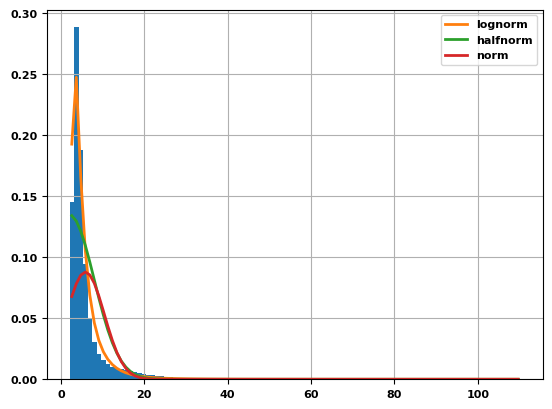

In [30]:
f_distributions_pow = Fitter(
    all_swrs_df["global_max_zscore"], distributions=["norm", "lognorm", "halfnorm"]
)
f_distributions_pow.fit()
f_distributions_pow.summary()

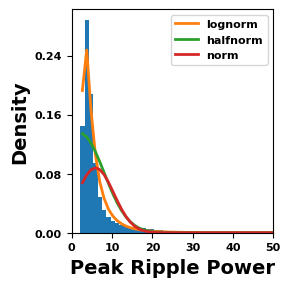

In [31]:
# Ensure text is exported as text objects
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["text.usetex"] = False  # Do not use LaTeX for rendering text
plt.rcParams["font.weight"] = "bold"
plt.rcParams["pdf.use14corefonts"] = False
plt.rcParams["font.size"] = 8
plt.rcParams["axes.titleweight"] = "bold"  # Make the title bold
plt.rcParams["axes.labelweight"] = "bold"

# set figzise in mm
width_mm = 66
height_mm = 73.75

# Set figure size in inches
plt.figure(figsize=(width_mm / 25.4, height_mm / 25.4))

# Plot the histogram
f_distributions_pow.hist()

# Plot the PDF
f_distributions_pow.plot_pdf()

# Get the current axes and turn off the grid
ax = plt.gca()
ax.grid(False)

# Set x-axis limits
# ax.set_xlim([0, 70])  # replace with your desired limits
# Reduce the number of y-ticks
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(5))
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(5))


# Set the title and axis labels
ax.set_xlabel("Peak Ripple Power", fontsize=14, weight="bold")
ax.set_ylabel("Density", fontsize=14, weight="bold")
ax.set_xlim([0, 50])
plt.savefig(f"{figure_six_path}six_coding_g.svg", format="svg")
# Display the plot
plt.show()

## Making Brain Images of Probes

Using this code you can take snapshots of the probe locations in CA1.

In [32]:
seshes = os.listdir(
    "/space/scratch/allen_visbehave_swr_data/allen_viscoding_swr_murphylab2024"
)
seshes = [s.replace("swrs_session_", "") for s in seshes if "swrs_session_" in s]
seshes = [int(s) for s in seshes]
abi_ripples_path

'/space/scratch/allen_visbehave_swr_data/allen_viscoding_swr_murphylab2024'

This code may be needed to be run in the terminal in order to set the notebook up for running brainrender in a notebook cell.

In [33]:
#!jupyter nbextension enable --py widgetsnbextension --sys-prefix

In [34]:
import random

import numpy as np

from brainrender import Scene
from brainrender.actors import Points
import vedo

vedo.settings.default_backend = "k3d"

from vedo import Plotter  # <- this will be used to render an embedded scene


# Display the Allen Brain mouse atlas.
scene = Scene(atlas_name="allen_mouse_25um", title="Inserts in CA1")
# Make sure it gets embedded in the window
scene.jupyter = True


def get_n_random_points_in_region(region, N):
    """
    Gets N random points inside (or on the surface) of a mes
    """

    region_bounds = region.mesh.bounds()
    X = np.random.randint(region_bounds[0], region_bounds[1], size=10000)
    Y = np.random.randint(region_bounds[2], region_bounds[3], size=10000)
    Z = np.random.randint(region_bounds[4], region_bounds[5], size=10000)
    pts = [[x, y, z] for x, y, z in zip(X, Y, Z)]

    ipts = region.mesh.inside_points(pts).coordinates
    return np.vstack(random.choices(ipts, k=N))


scene = Scene(title="Labelled cells")

# Display a brain region
cornu_Ammonis_1 = scene.add_brain_region("CA1", alpha=0.2)

ca1_coordinates = []

# Iterate over all subdirectories in the base directory
for dir_name in os.listdir(abi_ripples_path):
    if "swrs_session_" in dir_name:
        # Extract the session ID from the directory name and get the session data
        session_id = int(dir_name.split("swrs_session_")[1])
        session = cache.get_session_data(session_id)

        # Iterate over all files in the directory
        for file_name in os.listdir(os.path.join(abi_ripples_path, dir_name)):
            ca1_coordinates = []
            if "karlsson" in file_name:
                # Extract probe_id from the filename
                probe_id = int(re.search("probe_(.*?)_", file_name).group(1))

                # Get a list of all CA1 channel ids specific to the probe_id
                ca1index = session.channels[
                    (session.channels["ecephys_structure_acronym"] == "CA1")
                    & (session.channels["probe_id"] == probe_id)
                ].index

                # Get the coordinates for all CA1 channels specific to the probe_id
                ca1_coordinates = session.channels.loc[
                    ca1index,
                    [
                        "anterior_posterior_ccf_coordinate",
                        "dorsal_ventral_ccf_coordinate",
                        "left_right_ccf_coordinate",
                    ],
                ].values.astype(np.float32)
                # Extract the dorsal_ventral_ccf_coordinate values
                dorsal_ventral_values = ca1_coordinates[:, 1]

                # Sort the values
                sorted_values = np.sort(dorsal_ventral_values)

                # Calculate the mid-point
                mid_point_value = sorted_values[len(sorted_values) // 2]

                # Find the row with the mid-point value
                mid_point_row = ca1_coordinates[
                    np.where(ca1_coordinates[:, 1] == mid_point_value)
                ]

                scene.add(
                    Points(
                        mid_point_row,
                        name="probe_1",
                        colors="black",
                        radius=100,
                    )
                )

# Add label to the brain region
scene.add_label(cornu_Ammonis_1, "CA1")

# render
scene.content
scene.render()

plt = Plotter()
plt.show(*scene.renderables)

Cannot run function add_label in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

╭─────────────────────────────────╮
│                                 │
│   Scene actors                  │
│   ────────────                  │
│                                 │
│   - root (type: brain region)   │
│   - title (type: title)         │
│   - CA1 (type: brain region)    │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: [38;2

Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

/home/acampbell/miniconda3/envs/allensdk_env/lib/python3.10/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(


Plot(antialias=True, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], backgro…